In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('../data/dataset_merged.csv', lineterminator='\n')
df.head(5)

,debate_number,content_type,network,author,text,published_at,like_count,public
0,1,comment,CBS,@Deano-n4w,Donald Trump's reasoning is lost 😢,2024-08-27T09:51:01Z,0,True
1,1,comment,CBS,@noobpeepxpostyguitarists5381,2:05:31 this aged well,2024-08-26T09:48:00Z,0,True
2,1,comment,CBS,@noobpeepxpostyguitarists5381,The only facts is that words shouldn't be impo...,2024-08-26T09:44:19Z,1,True
3,1,comment,CBS,@sandhyagudigudi3998,Biden sir GodenBird flying ❤Trumpsir like Baby...,2024-08-22T02:10:30Z,0,True
4,1,comment,CBS,@cherylcallahan5402,LIONEL NATION AND THE MATE ARE THE BEST BEST,2024-08-21T17:11:52Z,1,True


In [3]:
df['network'].value_counts()

network
WSJ          81538
CSPAN        54333
FOX NEWS     21521
SKY NEWS     12332
MSNBC         6940
CBS           6632
NBC           6445
C-SPAN        2512
USA TODAY     1290
CNN18          545
WFLA           344
KH             321
WP             284
NEWSMAX        175
TW              87
CNBCTV18        10
WFAA             9
AP               6
Name: count, dtype: int64

In [4]:
# assigning media bias scores to networks
# allsides media chart - https://www.allsides.com/media-bias/media-bias-rating-methods
# left = -2, lean left = -1, center = 0, lean right = 1, right = 2

bias_scores = {
    'Wall Street Journal': 1,
    'C-SPAN': 0, # https://www.allsides.com/news-source/c-span
    'Fox News': 2,
    'Sky News': -1, # https://www.allsides.com/news-source/sky-news-media-bias
    'MSNBC': -2,
    'CBS': -1,
    'NBC': -1,
    'USA TODAY': -1,
    'CNN18': 0, # international network
    'WFLA': 0,
    "Kamala Harris's YouTube channel": -2,
    'Washington Post': -1,
    'NEWSMAX': 2,
    "Tim Walz'z YouTube channel": -2,
    'CNBCTV18': 0, # international network
    'WFAA': -1, # ABC affiliate; https://en.wikipedia.org/wiki/WFAA
    'Associated Press': -2
}

In [5]:
def calculate_bias(num):
    if num == -2:
        return 'Left'
    elif num == -1:
        return 'Lean Left'
    elif num == 1:
        return 'Lean Right'
    elif num == 2:
        return 'Right'
    else:
        return 'Center'

for k,v in bias_scores.items():
    print('{}: {}'.format(k, calculate_bias(v)))

Wall Street Journal: Lean Right
C-SPAN: Center
Fox News: Right
Sky News: Lean Left
MSNBC: Left
CBS: Lean Left
NBC: Lean Left
USA TODAY: Lean Left
CNN18: Center
WFLA: Center
Kamala Harris's YouTube channel: Left
Washington Post: Lean Left
NEWSMAX: Right
Tim Walz'z YouTube channel: Left
CNBCTV18: Center
WFAA: Lean Left
Associated Press: Left


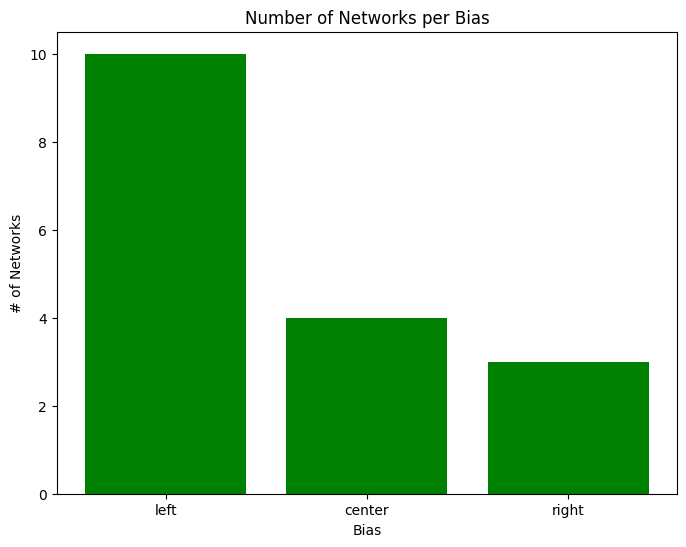

In [6]:
# visualizing bias vs channels

left_count, right_count, center_count = 0, 0, 0
networks = []

for network, score in bias_scores.items():
    networks.append(network)
    if score < 0:
        left_count += 1
    elif score > 0:
        right_count += 1
    else:
        center_count += 1

x = ['left', 'center', 'right']
y = [left_count, center_count, right_count]


plt.figure(figsize=(8, 6))
plt.bar(x, y, color='g')  

plt.title('Number of Networks per Bias')
plt.xlabel('Bias')
plt.ylabel('# of Networks')

plt.xticks(x)  

plt.show()

In [38]:
# mapping the bias scores to the 'network' column in your dataframe
df['bias_score'] = df['network'].map(bias_scores)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195324 entries, 0 to 195323
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   debate_number  195324 non-null  int64  
 1   content_type   195324 non-null  object 
 2   network        195324 non-null  object 
 3   author         195324 non-null  object 
 4   text           195324 non-null  object 
 5   published_at   195324 non-null  object 
 6   like_count     195324 non-null  int64  
 7   public         195324 non-null  bool   
 8   cluster        195324 non-null  int32  
 9   bias_score     24902 non-null   float64
dtypes: bool(1), float64(1), int32(1), int64(2), object(5)
memory usage: 12.9+ MB


In [39]:
import numpy as np

# bias label
conditions = [
    (df['bias_score'] < 0),
    (df['bias_score'] > 0)
]
choices = ['left', 'right']
df['bias_label'] = np.select(conditions, choices, default='center')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195324 entries, 0 to 195323
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   debate_number  195324 non-null  int64  
 1   content_type   195324 non-null  object 
 2   network        195324 non-null  object 
 3   author         195324 non-null  object 
 4   text           195324 non-null  object 
 5   published_at   195324 non-null  object 
 6   like_count     195324 non-null  int64  
 7   public         195324 non-null  bool   
 8   cluster        195324 non-null  int32  
 9   bias_score     24902 non-null   float64
 10  bias_label     195324 non-null  object 
dtypes: bool(1), float64(1), int32(1), int64(2), object(6)
memory usage: 14.3+ MB


In [11]:
# media bias discovery

# text preprocessing
df['text'] = df['text'].str.lower().str.replace('[^\w\s]', '')
print('Text preprocessed')

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
print('TF-IDF')

# PCA for initial dimension reduction for better t-SNE performance
pca = PCA(n_components=50)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())
print('PCA')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, learning_rate=200)
tfidf_tsne = tsne.fit_transform(tfidf_pca)
print('t-SNE')

Text preprocessed
TF-IDF
PCA
t-SNE


AttributeError: module 'pandas' has no attribute 'np'

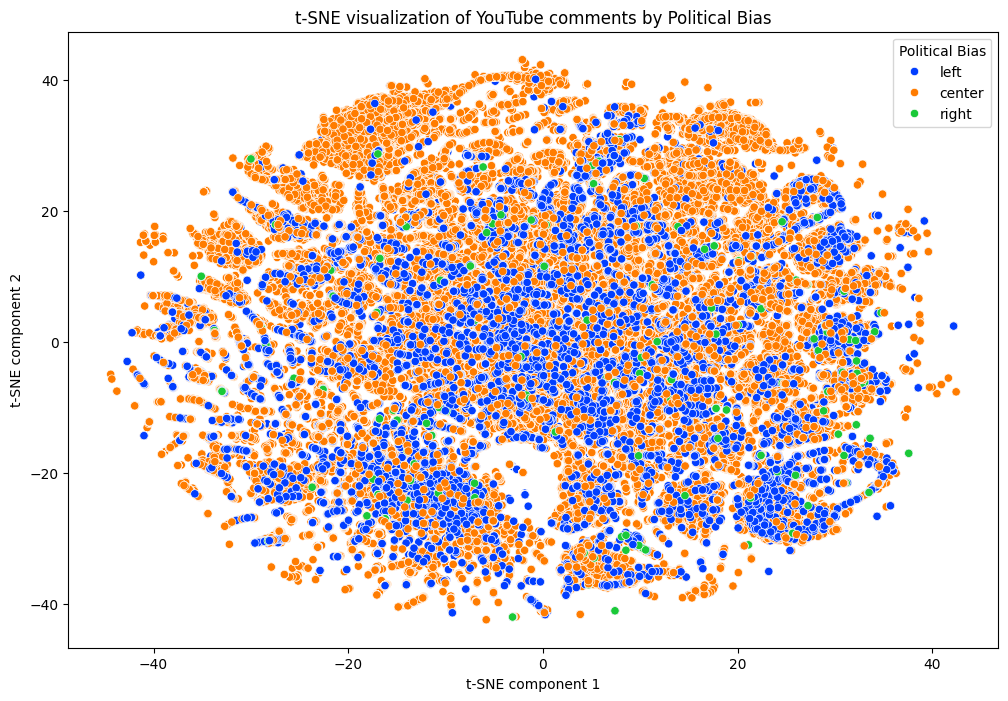

In [17]:
# visualization with 3 leanings

plt.figure(figsize=(12, 8))
sns.scatterplot(x=tfidf_tsne[:,0], y=tfidf_tsne[:,1], hue=df['bias_label'], palette='bright')
plt.title('t-SNE visualization of YouTube comments by Political Bias')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(title='Political Bias', loc='best')
plt.show()

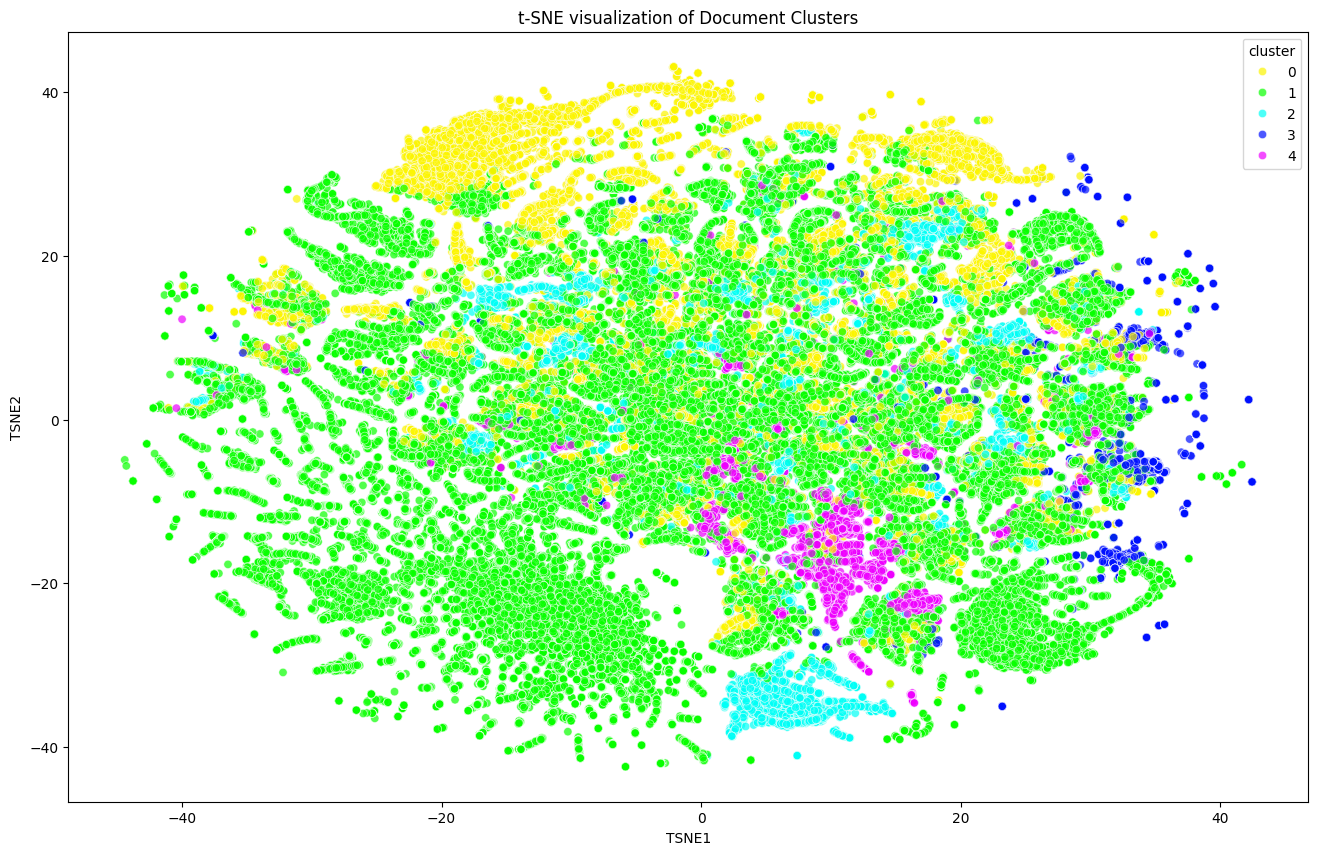

In [26]:
from sklearn.cluster import KMeans

num_clusters = 5  # optimal number of clusters
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)
clusters = km.labels_

df_tsne = pd.DataFrame(tfidf_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = clusters

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="cluster",
    palette=sns.color_palette("hsv", num_clusters),
    data=df_tsne,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE visualization of Document Clusters')
plt.show()

In [27]:
def get_top_features_cluster(tfidf_array, prediction, n_feats):
    labels = np.unique(prediction)
    _dfs = []
    for label in labels:
        id_temp = np.where(prediction==label)  # indices for each cluster
        x_means = np.mean(tfidf_array[id_temp], axis = 0)  # mean tf-idf value for each feature in the cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats]  # indices with top mean scores
        features = tfidf_vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        _df = pd.DataFrame(best_features, columns = ['features', 'score'])
        _dfs.append(_df)
    return _dfs

# Get the array representing the tf-idf values
tfidf_array = tfidf_matrix.toarray()

# Get the predictions from your kmeans model
prediction = km.labels_

# Choose the number of top words you want for each cluster
top_n_words = 10

# Get the top features (words) for each cluster
top_features_per_cluster = get_top_features_cluster(tfidf_array, prediction, top_n_words)

# Print the results
for i, _df in enumerate(top_features_per_cluster):
    print(f"Top {top_n_words} words for cluster {i}:")
    print(_df)
    print()

Top 10 words for cluster 0:
    features     score
0      biden  0.200818
1      trump  0.055137
2        joe  0.033445
3  president  0.025813
4       like  0.025566
5       just  0.016990
6      looks  0.014298
7        did  0.013719
8       time  0.012941
9    wallace  0.012843

Top 10 words for cluster 1:
    features     score
0      trump  0.034681
1  president  0.017872
2        joe  0.017347
3       like  0.015356
4       just  0.014604
5     people  0.014473
6    wallace  0.010724
7        don  0.009336
8       vote  0.009279
9      chris  0.009090

Top 10 words for cluster 2:
       features     score
0        debate  0.255522
1         trump  0.045378
2         biden  0.034827
3  presidential  0.027645
4       wallace  0.025602
5          like  0.022050
6           won  0.020335
7         chris  0.018366
8     moderator  0.016811
9          just  0.016505

Top 10 words for cluster 3:
    features     score
0      trump  0.509874
1       2024  0.184262
2       2020  0.166532
3